# Lego Detection Model

## Imports

In [102]:
import cv2
import numpy as np
import os
import math
from sklearn.cluster import KMeans
from scripts.utils import *
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import warnings

# Filter out K-mean warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

## Defining useful functions for the model

In [103]:

# 1. K-means clustering to get color regions
def kmeansBlur(img, blurQuantity = 3, clusterSize = 10):
    blurred = cv2.GaussianBlur(img, (blurQuantity, blurQuantity), 0)
    
    pixels = blurred.reshape((-1, 3))
    pixels = np.float32(pixels)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 1.0)
    _, labels, centers = cv2.kmeans(pixels, clusterSize, None, criteria, 12, cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    segmented_data = centers[labels.flatten()]
    segmented_image = segmented_data.reshape((img.shape))
    
    return segmented_image    

def drawEdgeImg(img, edges):
    edge_mask = np.zeros_like(img)
    edge_mask[edges > 0] = (255, 255, 255)
    edge_image = cv2.bitwise_and(img, edge_mask)
    return edge_image

# 2.1 Get the edges of the image with Canny edge detection
def getEdges(img, cannyThreshold1 = 100, cannyThreshold2 = 200, showGray = False):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if(showGray):
        print("Gray Image")
        render(gray)
    edges = cv2.Canny(gray, cannyThreshold1, cannyThreshold2)
    edge_image = drawEdgeImg(img, edges)
    return edges, edge_image

# 2.2 
def preprocessImg(og_img, numEdgeIterations = 3, kmeansBlurQuantity = 3, kmeansClusterSize = 10, cannyThreshold1 = 100, cannyThreshold2 = 200, contourConnectSize = 2, debug = False):
    edge_sum = np.zeros(og_img.shape[:2])
    
    for i in range(numEdgeIterations):
        segmented_img = kmeansBlur(og_img, kmeansBlurQuantity, kmeansClusterSize + i)    
        new_edges, _ = getEdges(segmented_img, cannyThreshold1, cannyThreshold2)
        
        """ if debug:
            print(f"Edges Image {i}")
            render(edge_img) """
        
        edge_sum += new_edges

    # Threshold the accumulated edges so that at least 1/2 of iterations agree
    edges = (edge_sum >= (numEdgeIterations / 2)).astype(np.uint8) * 255

    if debug:
        print("Final Edges Image")
        render(drawEdgeImg(og_img, edges))
        
    contour_image, contours = getContours(og_img, edges, contourConnectSize)
    
    if debug:
        print("Contours of the Edges")
        render(contour_image)
        
    return contours


# 3. Get the contours of the edges in the image
def getContours(img, edges, connectSize = 3):
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (connectSize, connectSize))
    dilated_edges = cv2.dilate(edges, kernel)
    contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_image = img.copy()
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)
    return contour_image, contours

# 4.1 Check if two bounding boxes overlap more than a certain threshold
def checkIfBBOverlap(bb1, bb2, intersectionThreshold = 0.2):
    x1, y1, w1, h1 = bb1
    x2, y2, w2, h2 = bb2
    intersection_area = max(0, min(x1+w1, x2+w2) - max(x1, x2)) * max(0, min(y1+h1, y2+h2) - max(y1, y2))
    union_area = w1 * h1 + w2 * h2 - intersection_area
    return intersection_area / union_area > intersectionThreshold

# 4.2 Check if bb1 is contained within bb2
def checkIfBBContained(bb1, bb2):
    x1, y1, w1, h1 = bb1
    x2, y2, w2, h2 = bb2
    return x1 >= x2 and y1 >= y2 and x1 + w1 <= x2 + w2 and y1 + h1 <= y2 + h2

# 4.3 Remove contained bounding boxes
def remove_contained_rectangles(bounding_rectangles):

    if len(bounding_rectangles) < 2:
        return bounding_rectangles
    
    rectangles_to_remove = []

    # Iterate through each pair of bounding boxes
    for i in range(len(bounding_rectangles)):
        for j in range(i + 1, len(bounding_rectangles)):
            
            try:
                bb1 = bounding_rectangles[i]
                bb2 = bounding_rectangles[j]

                # Check if one bounding box is contained within the other
                if checkIfBBContained(bb1, bb2):
                    rectangles_to_remove.append(i)
                elif checkIfBBContained(bb2, bb1):
                    rectangles_to_remove.append(j)
            except:
                continue

    # Remove the contained rectangles
    bounding_rectangles = [bb for i, bb in enumerate(bounding_rectangles) if i not in rectangles_to_remove]

    return bounding_rectangles

# 4.4 Remove overlapping bounding boxes
def remove_overlapping_rectangles(bounding_rectangles, intersection_threshold):

    if len(bounding_rectangles) < 2:
        return bounding_rectangles
    
    # Iterate through each pair of bounding boxes
    for i in range(len(bounding_rectangles)):
        for j in range(i + 1, len(bounding_rectangles)):
            
            try:
                bb1 = bounding_rectangles[i]
                bb2 = bounding_rectangles[j]

                # Check if the bounding boxes overlap more than the threshold
                if checkIfBBOverlap(bb1, bb2, intersection_threshold):
                    
                    # Remove the smallest bounding box of the pair
                    if bb1[2] * bb1[3] < bb2[2] * bb2[3]:
                        bounding_rectangles.remove(bb1)
                    else:
                        bounding_rectangles.remove(bb2)
            except:
                continue

    return bounding_rectangles

# 4.5 Get the bounding boxes for the legos based on the contours edges, removing possible false matches
def getBoundingBoxes(img, contours, minPossibleArea = 100, boundingBoxMaxPossibleAreaRatio = 0.3, intersectionThreshold = 0.2, numEdgeIterations = 3, kmeansBlurQuantity = 3, kmeansClusterSize = 10, cannyThreshold1 = 100, cannyThreshold2 = 200, contourConnectSize = 2, debug = False):
    
    num_legos = 0
    bounding_box_image = img.copy()
    bounding_rectangles = []

    if debug:
        temp = bounding_box_image.copy()
        counter = 0
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(temp, (x, y), (x + w, y + h), (0, 255, 0), 2)
            counter += 1
        render(temp)
    
    if counter > 15:
        print("Detected too many bounding boxes, using kmeans again to reduce noise.")
        blurred = cv2.GaussianBlur(img, (9, 9), 0)
        contours = preprocessImg(blurred, numEdgeIterations, kmeansBlurQuantity, kmeansClusterSize, cannyThreshold1, cannyThreshold2, contourConnectSize, False)
    
    for contour in contours:
        
        x, y, w, h = cv2.boundingRect(contour)
        area = w * h
        
        # Ignore small area rectangles because they are likely noise
        if area < minPossibleArea:
            continue
        
        # Ignore large area rectangles because they are likely to be the entire image
        if area > boundingBoxMaxPossibleAreaRatio * img.shape[0] * img.shape[1]:
            continue
        
        bounding_rectangles.append((x, y, w, h))
        
    # Sort the bounding boxes by area in descending order
    bounding_rectangles = sorted(bounding_rectangles, key=lambda x: x[2] * x[3], reverse=True)

    # Remove bounding boxes that are contained within other bounding boxes
    bounding_rectangles = remove_contained_rectangles(bounding_rectangles)

    # Check each bb pair and remove the smallest of the pair if they overlap more than threshold
    bounding_rectangles = remove_overlapping_rectangles(bounding_rectangles, intersectionThreshold)
    
    # Draw the bounding boxes on the image
    for x, y, w, h in bounding_rectangles:
        cv2.rectangle(bounding_box_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        num_legos += 1
        
    return num_legos, bounding_box_image, bounding_rectangles



In [104]:
# 5.1 Get the image contained in a bounding box
def getBoundingBoxImage(img, box):
    x, y, w, h = box
    cropped_image = img[y:y+h, x:x+w]
    return cropped_image
       
# 5.2 Display a square of a specific color in RGB format
def display_color_square(color):
    color = (color[0] / 255, color[1] / 255, color[2] / 255)
    _, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    rectangle = plt.Rectangle((0, 0), 1, 1, color=color)
    ax.add_patch(rectangle)
    name = f"({color[0] * 255:.0f}, {color[1] * 255:.0f}, {color[2] * 255:.0f})"
    ax.text(0.5, 0.5, name, ha='center', va='center', color='black', bbox=dict(facecolor='white', edgecolor='white'))
    ax.axis('off')
    plt.show()   
    
# Returns the foreground mask, which will be used to extract the lego color
def getGrabCutMask(img):
    mask = np.zeros(img.shape[:2], np.uint8)
    bgModel = np.zeros((1, 65), np.float64)
    fgModel = np.zeros((1, 65), np.float64)
    rect = (0, 0, img.shape[1] - 1, img.shape[0] - 1)
    cv2.grabCut(img, mask, rect, bgModel, fgModel, 5, cv2.GC_INIT_WITH_RECT)
    mask = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 1, 0).astype('uint8')
    return mask 

# Get the color of the lego piece
def getLegoColor(lego_img, numClusters=8, blurQnt=5):
    fg_mask = getGrabCutMask(lego_img)
    
    # Apply a blur to the image to reduce noise
    lego_img_blurred = cv2.GaussianBlur(lego_img, (blurQnt, blurQnt), 0)
    
    # Apply K-means clustering to reduce the number of colors
    try:
        pixels = lego_img_blurred.reshape((-1, 3))
        kmeans_all = KMeans(n_clusters=numClusters, n_init=10, max_iter=300, tol=1e-4, random_state=0)
        kmeans_all.fit(pixels)
        lego_img_kmeans = kmeans_all.cluster_centers_[kmeans_all.labels_].reshape(lego_img_blurred.shape).astype(np.uint8)
        lego_img_blurred = lego_img_kmeans
    except:
        print("Failed to reduce the color space for lego color extraction")
    
    
    # Mask out the background
    fg_pixels = lego_img_blurred[np.where(fg_mask == 1)]
    
    # Masked image
    temp = cv2.bitwise_and(lego_img_blurred, lego_img_blurred, mask=fg_mask)
    render(temp)
    
    # Apply k-means clustering to get the most common color
    try:
        kmeans = KMeans(n_clusters=numClusters, n_init=10, max_iter=300, tol=1e-4, random_state=0)
        kmeans.fit(fg_pixels)
        most_common_color = Counter(kmeans.labels_).most_common(1)[0][0]
        color = kmeans.cluster_centers_[most_common_color].astype(np.uint8)
    except:
        # if k-mean fails for some reason, like the grab cut deleting the piece itself, use a default color
        print("K-means clustering failed to extract lego color")
        color = np.array([255, 255, 255], dtype=np.uint8)  # Default color is white
    
    color_rgb = color[..., ::-1]
 
    return color_rgb

# 6.1 Get the bounding box lego color
def getBBColor(og_img, box, blurQnt = 5, showResults = False):
  
    # Extract the bounding box image from the original image
    lego_img = getBoundingBoxImage(og_img, box)
    
    if showResults:
        render(lego_img)
    
    # Get the most common color in the bounding box image, which should be the color of the lego
    color = getLegoColor(lego_img, blurQnt=blurQnt)
    
    # Display the lego image without the background and the lego color
    if showResults:
        try:
            display_color_square(color)
        except:
            print("ERROR: No color was found for this lego piece.")
            color = (0, 0, 0)
        
    return color
    
# 6.2 Number of Different Lego Colors
def getNumDifferentColors(og_img, boxes, bbColorBlurQnt = 5,  sameColorDistanceThreshold = 20, showResults=False):
    colors = []
    
    def colorDistance(color1, color2):
            return ((color1[0] - color2[0]) ** 2 + (color1[1] - color2[1]) ** 2 + (color1[2] - color2[2]) ** 2) ** 0.5

    for box in boxes:
        color = getBBColor(og_img, box, bbColorBlurQnt, showResults)
        # Check if the color is similar to any previously recorded color
        similar_color_found = False

        for recorded_color in colors:
            if colorDistance(color, recorded_color) <= sameColorDistanceThreshold:
                similar_color_found = True
                break
        if not similar_color_found:
            colors.append(color)
        
    return len(colors), colors


# 7.1 Evaluate results for lego counting
def guessPieceCount(imgID, legoNum, showResults = False):
    # Load the csv file as pd
    df = pd.read_csv("scripts/lego_sets.csv")
    
    # compare legoNum to column piece_count in id row
    piece_count = df.loc[df['id'] == imgID, 'piece_count'].values[0]
    
    if(showResults):
        if(legoNum == piece_count):
            print("Guessed correct number of legos!")
        else:
            (f"Guessed: {legoNum} | Actual: {piece_count} legos") 
        
    return piece_count 

# 7.2 Guess the number of lego colors
def guessColorCount(imgID, colorNum, showResults = False):
    # Load the csv file as pd
    df = pd.read_csv("scripts/lego_sets.csv")
    
    # compare legoNum to column piece_count in id row
    color_arr = df.loc[df['id'] == imgID, 'piece_colors'].values[0]
    
    # Count the number of "-" in the string
    color_count = color_arr.count("-") + 1
    
    if(showResults):
        if(colorNum == color_count):
            print("Guessed correct number of colors!")
        else:
            (f"Guessed: {colorNum} | Actual: {color_count} colors") 
        
    return color_count 



## Defining the model

In [105]:
def model(image_id, debug=False, ignoreColor=False, showBBImg=False):
    
    # Contours Configurations
    kmeansBlurQuantity = 1
    kmeansClusterSize = 8
    cannyThreshold1 = 110
    cannyThreshold2 = 200
    numEdgeIterations = 10
    contourConnectSize = 2
    
    # Bounding Box Configurations
    boundingBoxMinPossibleArea = 200
    boundingBoxMaxPossibleAreaRatio = 0.3
    boundingBoxIntersectionThreshold = 0.25
    
    # BB Color Configurations
    bbColorBlurQnt = 31
    sameColorDistanceThreshold = 50
    
    # Load the image
    og_img = loadImage(image_id)
    
    if debug:
        print("Original Image")
        render(og_img)
    
    # contours the image to extract the edges and contours
    contours = preprocessImg(og_img, numEdgeIterations, kmeansBlurQuantity, kmeansClusterSize, cannyThreshold1, cannyThreshold2, contourConnectSize, debug)
    
    # Bounding box evaluation
    num_legos_guess, bounding_box_image, boxes = getBoundingBoxes(og_img, contours, boundingBoxMinPossibleArea, boundingBoxMaxPossibleAreaRatio, boundingBoxIntersectionThreshold, numEdgeIterations, kmeansBlurQuantity, kmeansClusterSize, cannyThreshold1, cannyThreshold2, contourConnectSize, debug)
    
    if debug or showBBImg:
        print("Bounding Boxes: " + str(num_legos_guess))
        render(bounding_box_image)
            
    # Color evaluation
    if not ignoreColor:
        if debug:
            print("\n================== Color Extraction ==================\n")
        num_colors_guess, color_list = getNumDifferentColors(og_img, boxes, bbColorBlurQnt, sameColorDistanceThreshold, debug)
        
        if debug:
            print("Colors list: " + str(color_list))
    
    # Make the guesses
    piece_count = guessPieceCount(image_id, num_legos_guess)
    if not ignoreColor:
        color_count = guessColorCount(image_id, num_colors_guess)
    
    if(debug):
        print(f"Lego Count: {num_legos_guess} | {piece_count}")
        if not ignoreColor:
            print(f"Lego Color: {num_colors_guess} | {color_count}")
        
    # Calculate error
    num_legos_error = abs(num_legos_guess - piece_count)
    if not ignoreColor:
        num_colors_error = abs(num_colors_guess - color_count)
    else:
        num_colors_error = 0
        num_colors_guess = 0
        color_count = 0
        
    return piece_count, color_count, num_legos_guess, num_colors_guess, num_legos_error, num_colors_error

## Model Execution on an Image

In [106]:
# _ = model(11, True)

## Applying the model to all images

In [107]:
def evaluate_model(debug=False, onlyCheckingNums=False, int1=0, int2=0):
    total_lego_error = 0
    total_color_error = 0
    total_lego = 0
    total_color = 0
    
    error_lego_ids = []

    for i in range(int1, int2):
        print(f"\n======================== Image {i} ========================\n")
        piece_count, color_count, num_legos_guess, num_colors_guess, num_legos_error, num_colors_error = model(i, True, onlyCheckingNums)
        
        if debug:
            if(num_legos_error > 0):
                print(f"Error in Lego Count - Guessed: {num_legos_guess} | Actual: {piece_count} legos")
                error_lego_ids.append(i)
                
            if(num_colors_error > 0):
                print(f"Error in Lego Color - Guessed: {num_colors_guess} | Actual: {color_count} colors")
                error_lego_ids.append(i)
            if num_legos_error == 0 and num_colors_error == 0:
                print("Perfect guess!")
            
        total_lego_error += num_legos_error
        total_color_error += num_colors_error
        total_lego += piece_count
        total_color += color_count
    
    error_lego_ids = set(error_lego_ids)
     
    if debug:    
        print(f"\n\n======================== TOTAL RESULTS ========================")   
        print(f"Total Lego Error: {total_lego_error} | {total_lego}")
        print(f"Total Color Error: {total_color_error} | {total_color}")
        print("Num of images with errors: " + str(len(error_lego_ids)))
        print("Error images: " + str(error_lego_ids))
        print("===============================================================")
        
    return total_lego_error, total_color_error, error_lego_ids


======================== Image 0 ========================

Original Image


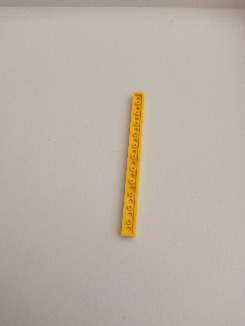

Final Edges Image


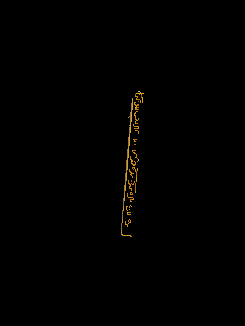

Contours of the Edges


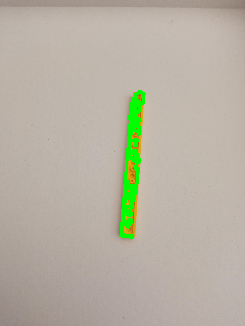

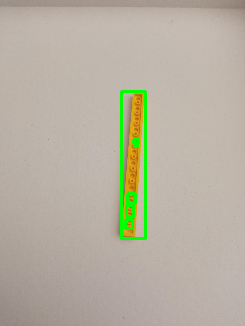

Bounding Boxes: 1


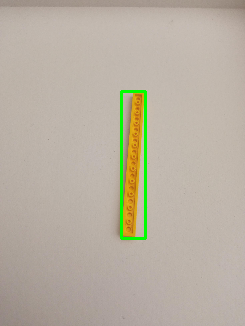


================== Color Extraction ==================



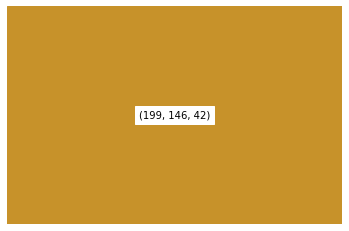

Colors list: [array([199, 146,  42], dtype=uint8)]
Lego Count: 1 | 1
Lego Color: 1 | 1
Perfect guess!

======================== Image 1 ========================

Original Image


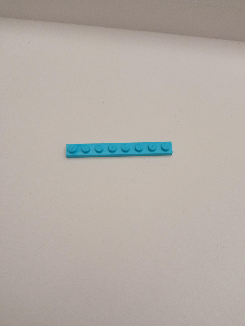

Final Edges Image


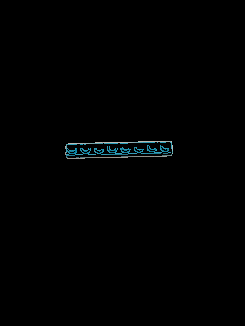

Contours of the Edges


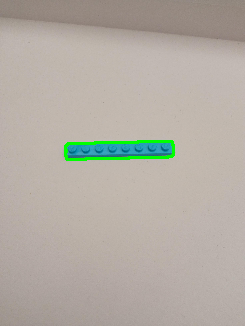

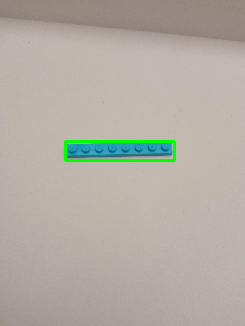

Bounding Boxes: 1


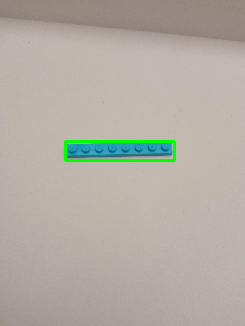


================== Color Extraction ==================



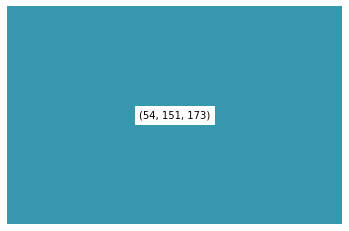

Colors list: [array([ 54, 151, 173], dtype=uint8)]
Lego Count: 1 | 1
Lego Color: 1 | 1
Perfect guess!

======================== Image 2 ========================

Original Image


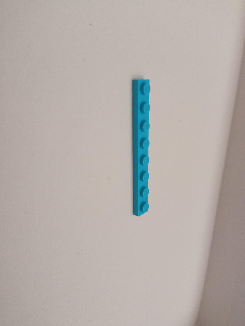

Final Edges Image


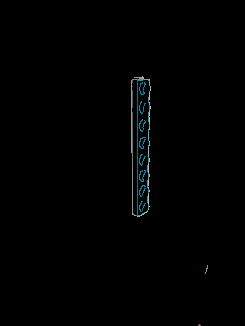

Contours of the Edges


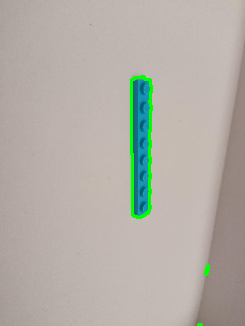

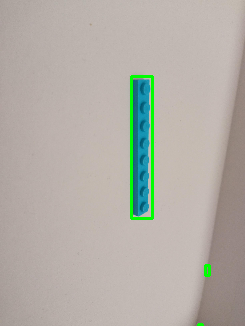

Bounding Boxes: 1


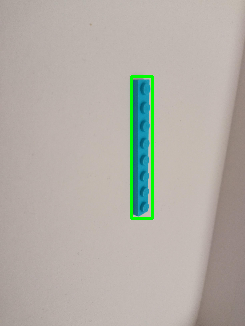


================== Color Extraction ==================



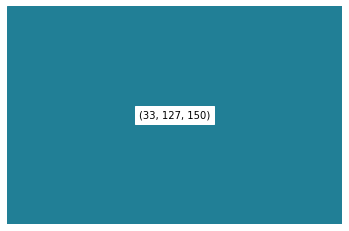

Colors list: [array([ 33, 127, 150], dtype=uint8)]
Lego Count: 1 | 1
Lego Color: 1 | 1
Perfect guess!

======================== Image 3 ========================

Original Image


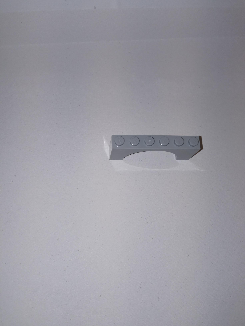

Final Edges Image


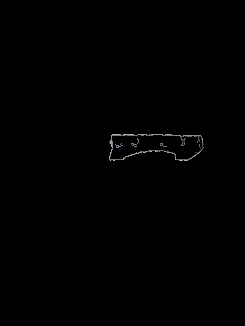

Contours of the Edges


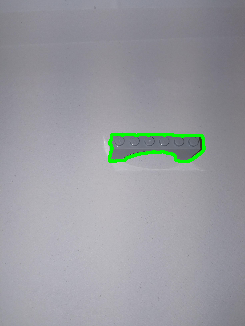

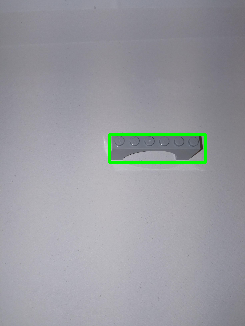

Bounding Boxes: 1


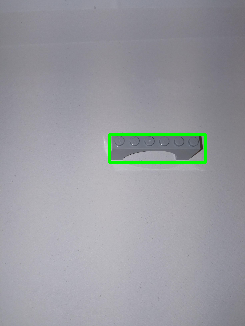


================== Color Extraction ==================



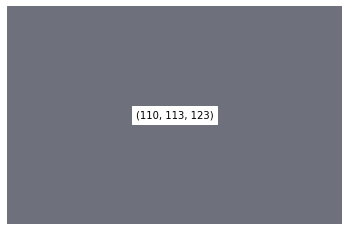

Colors list: [array([110, 113, 123], dtype=uint8)]
Lego Count: 1 | 1
Lego Color: 1 | 1
Perfect guess!

======================== Image 4 ========================

Original Image


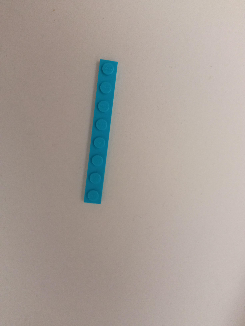

Final Edges Image


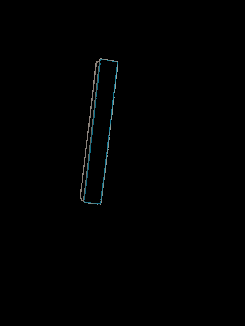

Contours of the Edges


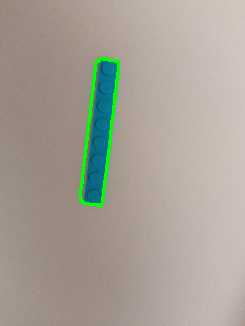

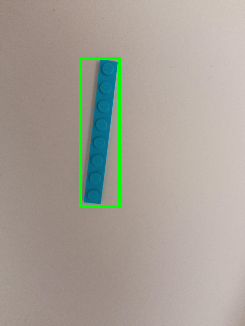

Bounding Boxes: 1


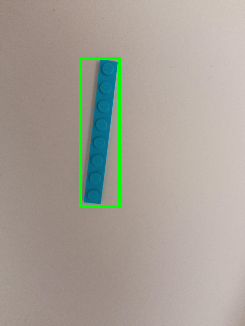


================== Color Extraction ==================



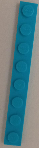

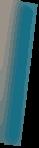

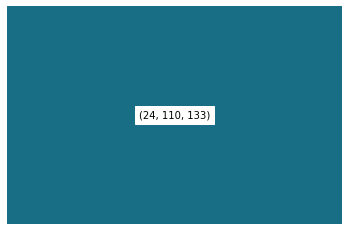

Colors list: [array([ 24, 110, 133], dtype=uint8)]
Lego Count: 1 | 1
Lego Color: 1 | 1
Perfect guess!

======================== Image 5 ========================

Original Image


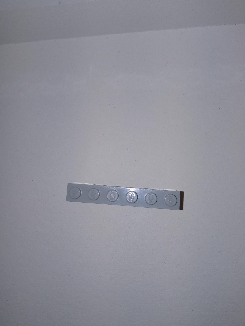

Final Edges Image


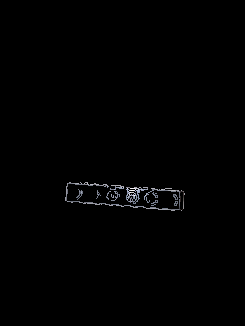

Contours of the Edges


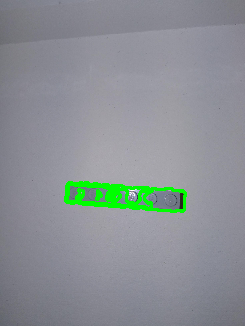

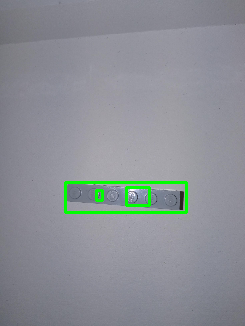

Bounding Boxes: 1


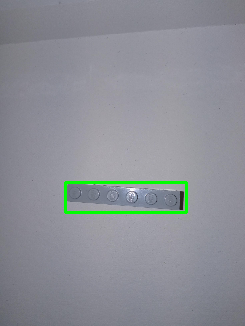


================== Color Extraction ==================



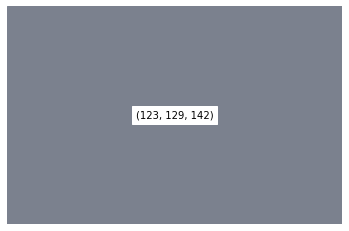

Colors list: [array([123, 129, 142], dtype=uint8)]
Lego Count: 1 | 1
Lego Color: 1 | 1
Perfect guess!

======================== Image 6 ========================

Original Image


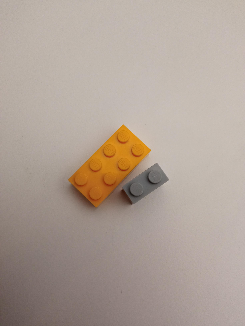

Final Edges Image


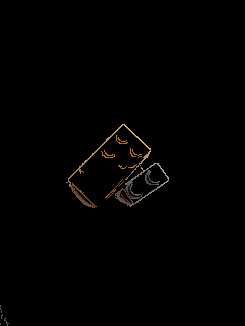

Contours of the Edges


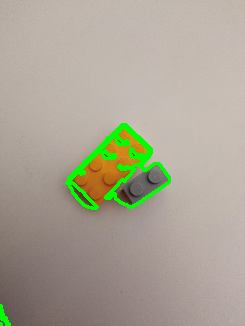

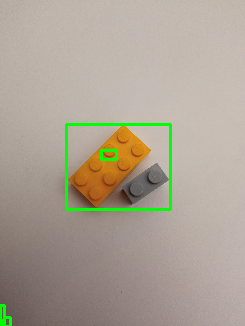

Bounding Boxes: 1


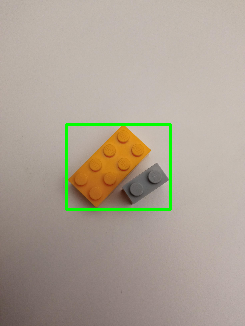


================== Color Extraction ==================



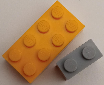

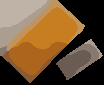

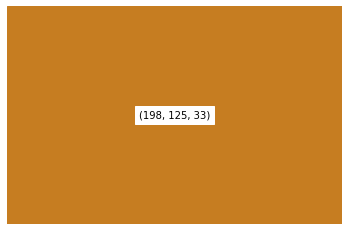

Colors list: [array([198, 125,  33], dtype=uint8)]
Lego Count: 1 | 2
Lego Color: 1 | 2
Error in Lego Count - Guessed: 1 | Actual: 2 legos
Error in Lego Color - Guessed: 1 | Actual: 2 colors

======================== Image 7 ========================

Original Image


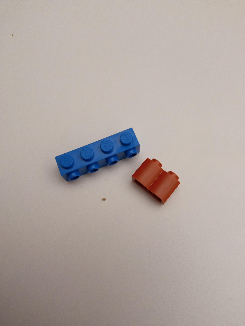

Final Edges Image


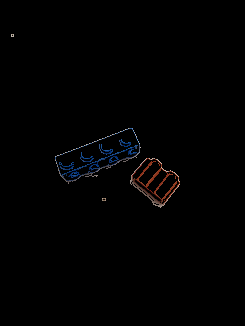

Contours of the Edges


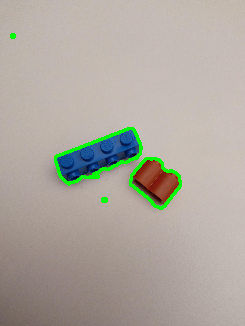

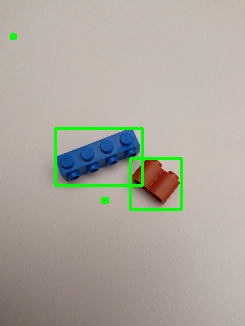

Bounding Boxes: 2


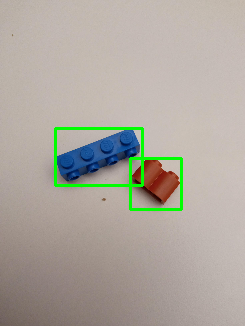


================== Color Extraction ==================



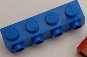

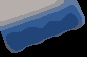

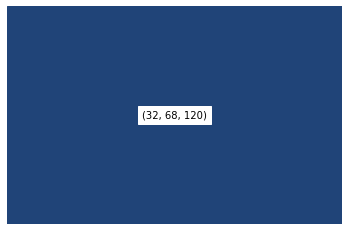

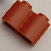

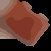

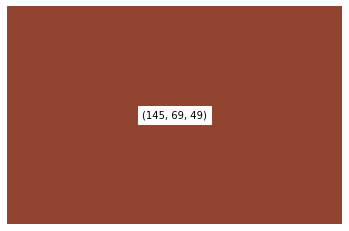

Colors list: [array([ 32,  68, 120], dtype=uint8), array([145,  69,  49], dtype=uint8)]
Lego Count: 2 | 2
Lego Color: 2 | 2
Perfect guess!

======================== Image 8 ========================

Original Image


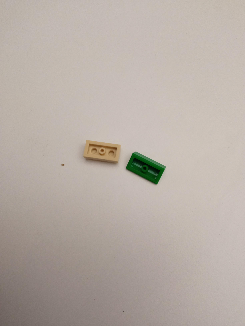

Final Edges Image


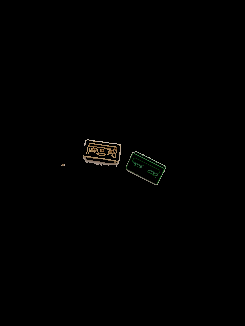

Contours of the Edges


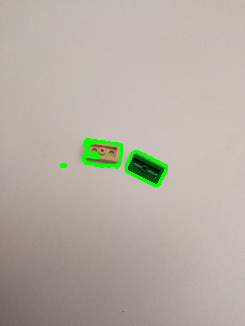

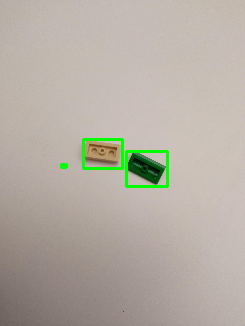

Bounding Boxes: 2


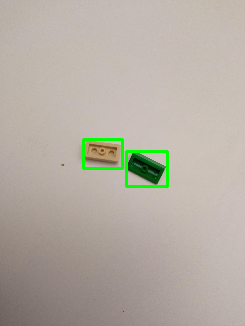


================== Color Extraction ==================



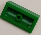

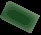

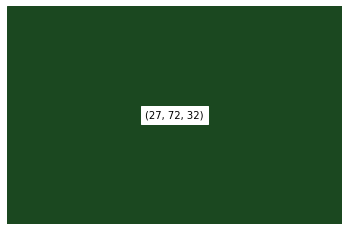

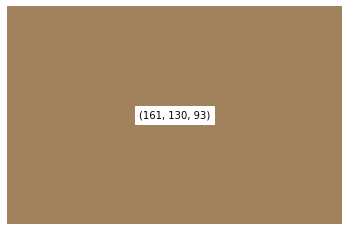

Colors list: [array([27, 72, 32], dtype=uint8), array([161, 130,  93], dtype=uint8)]
Lego Count: 2 | 2
Lego Color: 2 | 2
Perfect guess!

======================== Image 9 ========================

Original Image


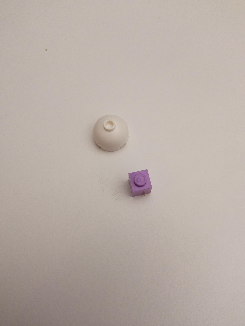

Final Edges Image


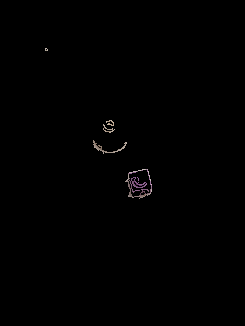

Contours of the Edges


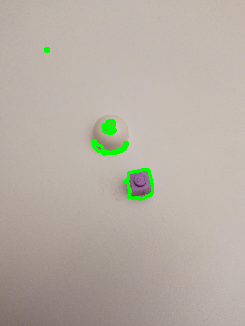

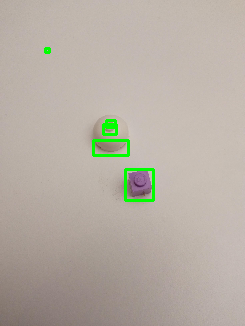

Bounding Boxes: 2


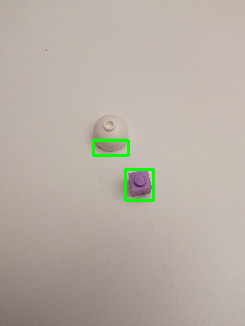


================== Color Extraction ==================



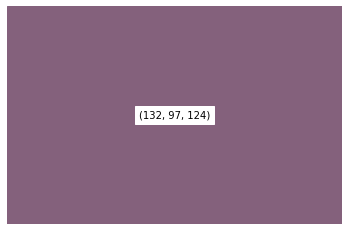

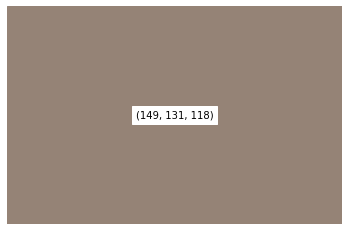

Colors list: [array([132,  97, 124], dtype=uint8), array([149, 131, 118], dtype=uint8)]
Lego Count: 2 | 2
Lego Color: 2 | 2
Perfect guess!

======================== Image 10 ========================

Original Image


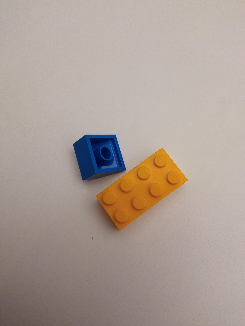

Final Edges Image


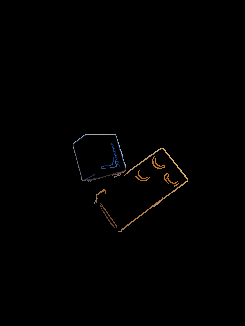

Contours of the Edges


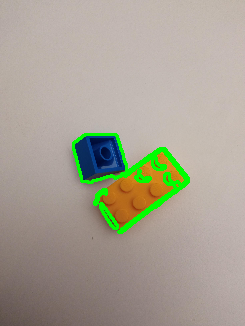

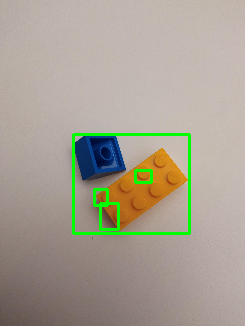

Bounding Boxes: 1


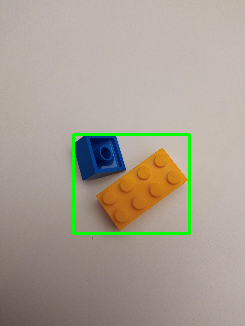


================== Color Extraction ==================



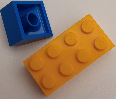

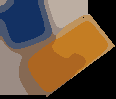

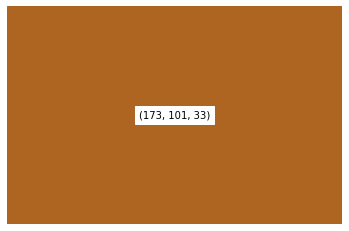

Colors list: [array([173, 101,  33], dtype=uint8)]
Lego Count: 1 | 2
Lego Color: 1 | 2
Error in Lego Count - Guessed: 1 | Actual: 2 legos
Error in Lego Color - Guessed: 1 | Actual: 2 colors

======================== Image 11 ========================

Original Image


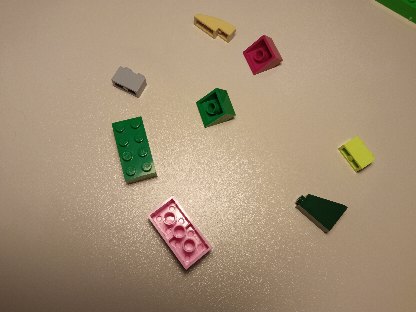

Final Edges Image


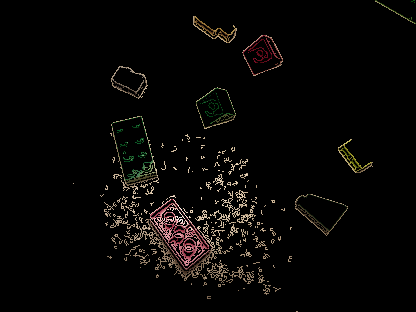

Contours of the Edges


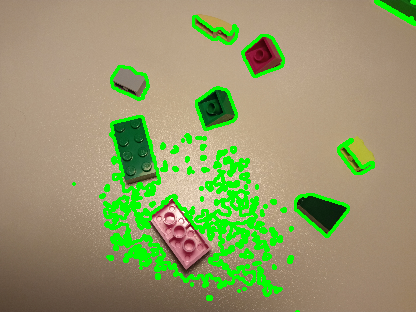

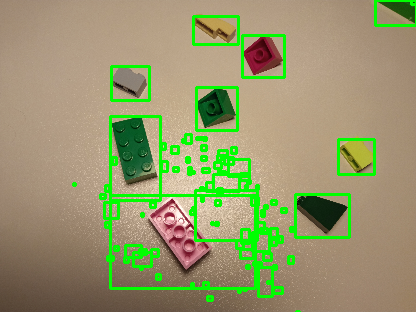

Detected too many bounding boxes, using kmeans again to reduce noise.
Bounding Boxes: 9


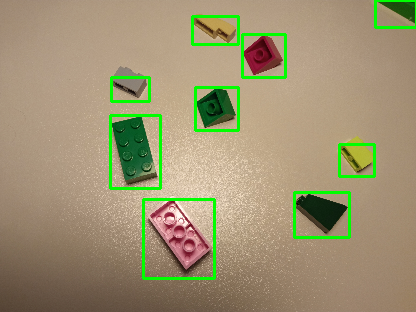


================== Color Extraction ==================



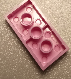

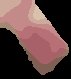

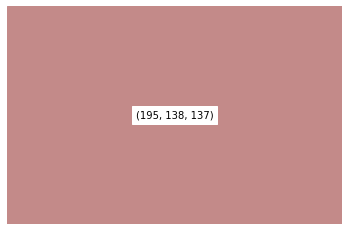

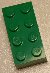

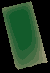

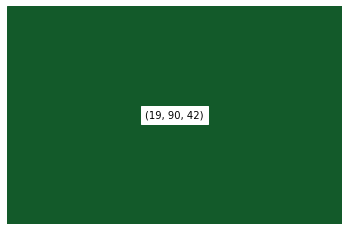

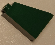

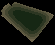

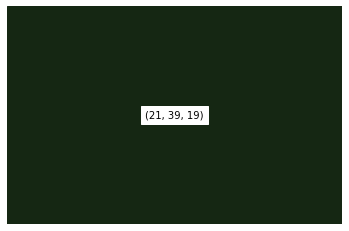

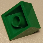

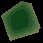

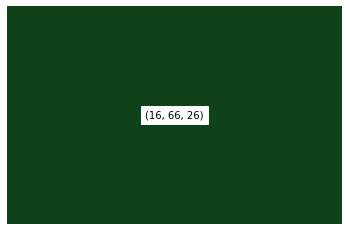

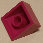

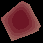

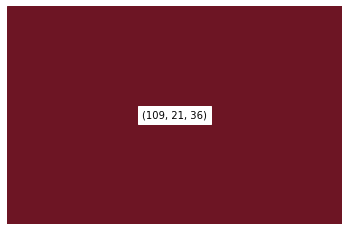

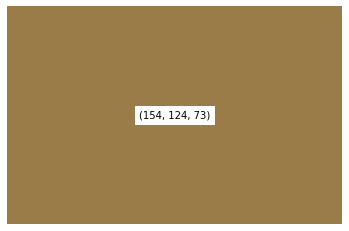

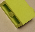

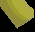

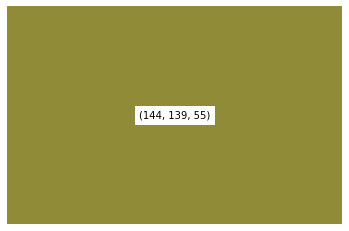

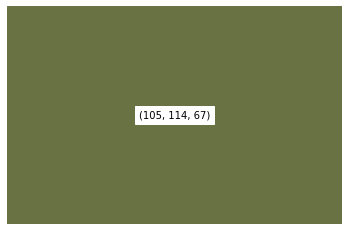

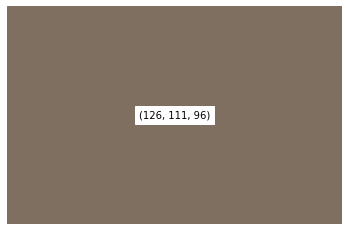

Colors list: [array([195, 138, 137], dtype=uint8), array([19, 90, 42], dtype=uint8), array([21, 39, 19], dtype=uint8), array([16, 66, 26], dtype=uint8), array([109,  21,  36], dtype=uint8), array([154, 124,  73], dtype=uint8), array([144, 139,  55], dtype=uint8), array([105, 114,  67], dtype=uint8), array([126, 111,  96], dtype=uint8)]
Lego Count: 9 | 9
Lego Color: 9 | 6
Error in Lego Color - Guessed: 9 | Actual: 6 colors

======================== Image 12 ========================

Original Image


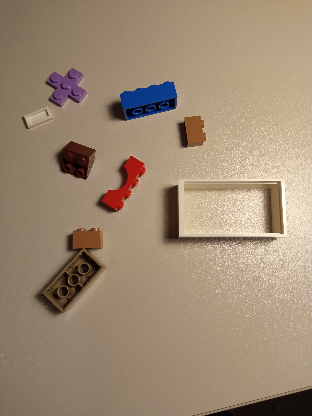

Final Edges Image


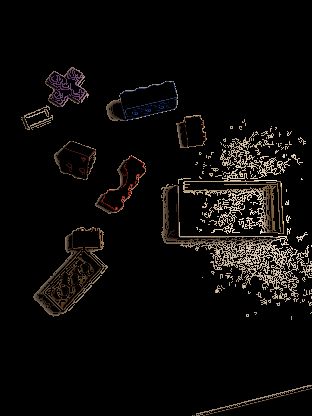

Contours of the Edges


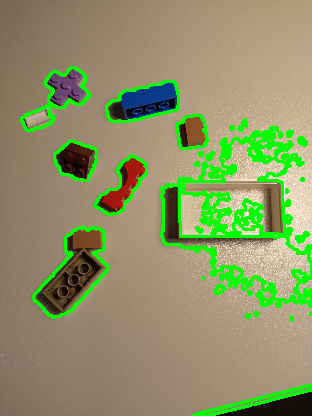

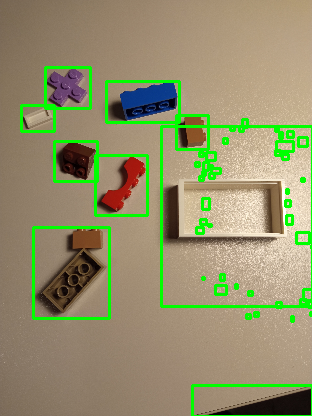

Detected too many bounding boxes, using kmeans again to reduce noise.
Bounding Boxes: 8


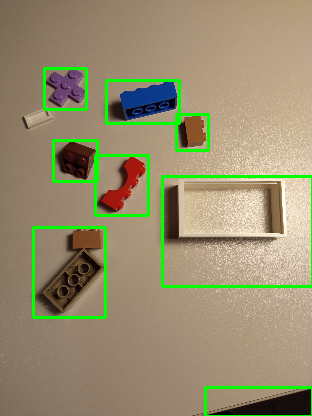


================== Color Extraction ==================



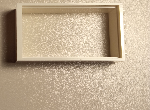

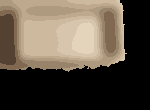

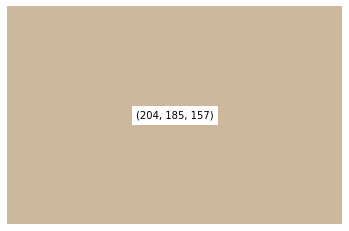

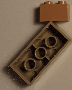

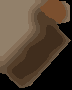

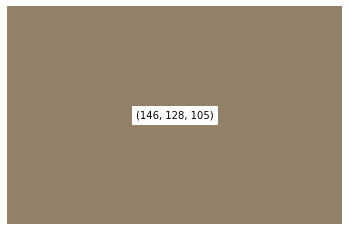

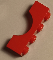

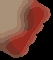

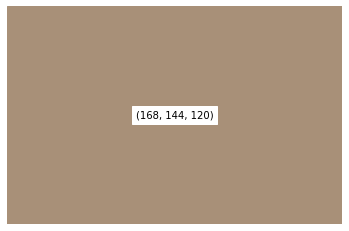

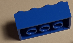

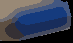

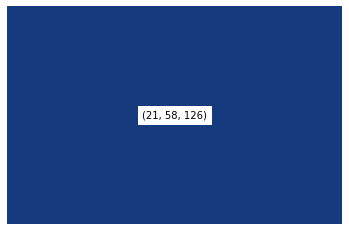

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 180, in where
  File "/home/m/.local/lib/python3.10/site-packages/numpy/core/multiarray.py", line 345, in where
    @array_function_from_c_func_and_dispatcher(_multiarray_umath.where)
KeyboardInterrupt: 


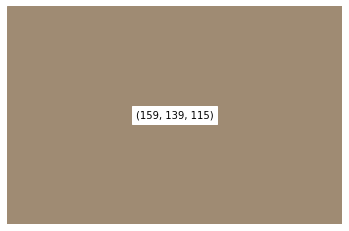

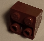

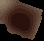

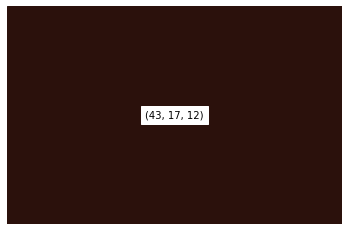

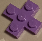

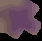

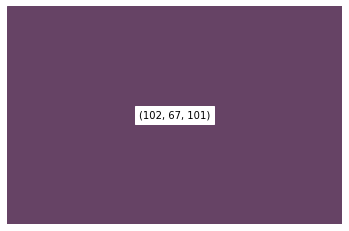

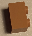

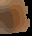

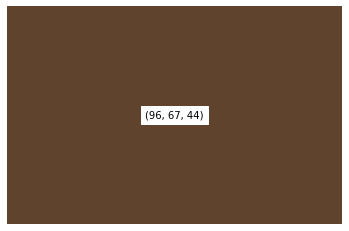

Colors list: [array([204, 185, 157], dtype=uint8), array([146, 128, 105], dtype=uint8), array([ 21,  58, 126], dtype=uint8), array([43, 17, 12], dtype=uint8), array([102,  67, 101], dtype=uint8), array([96, 67, 44], dtype=uint8)]
Lego Count: 8 | 9
Lego Color: 6 | 6
Error in Lego Count - Guessed: 8 | Actual: 9 legos

======================== Image 13 ========================

Original Image


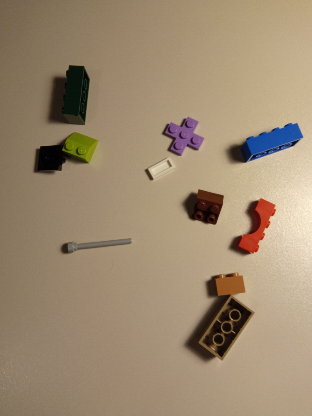

In [108]:
_ = evaluate_model(True, False, 0, 21)